In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from random import shuffle

import pandas as pd

import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

#from scipy.misc import imread, imresize

%matplotlib inline

In [3]:
ALL_DATA_DIR = '/home/HDD6TB/datasets/emotions/'
INPUT_SIZE = (224, 224)
#INPUT_SIZE = (299, 299)

In [4]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm


print(f"Torch: {torch.__version__}")

Torch: 1.7.1+cu110


In [11]:
use_cuda = torch.cuda.is_available()
device = 'cuda' if use_cuda else 'cpu'
print(use_cuda,device)

True cuda


In [5]:
USE_ENET2=False #True #

In [6]:
IMG_SIZE=260 if USE_ENET2 else 224 # 300 # 80 #
train_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
print(test_transforms)

Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [7]:
USE_MTL=False
if USE_ENET2:
    if False: # 7 emotions
        PATH='../../models/affectnet_emotions/enet_b2_7.pt'
        model_name='enet2_7_pt'
    else:
        #PATH='../../models/affectnet_emotions/enet_b2_8.pt'
        PATH='../../models/affectnet_emotions/enet_b2_8_best.pt'
        model_name='enet2_8_pt'
else:
    if False: # 7 emotions from AFFECT_IMG_SEVEN_TRAIN_DATA_DIR and AFFECT_IMG_SEVEN_VAL_DATA_DIR
        PATH='../../models/affectnet_emotions/enet_b0_7.pt'
        model_name='enet0_7_pt'
    elif True:
        #PATH='../../models/affectnet_emotions/enet_b0_8_best_vgaf.pt'
        PATH='../../models/affectnet_emotions/enet_b0_8_best_afew.pt'
        model_name='enet0_8_pt'
    else:
        PATH='../../models/affectnet_emotions/enet_b0_8_va_mtl.pt'
        model_name='enet0_8_mtl_pt'
        USE_MTL=True
print(PATH)

../../models/affectnet_emotions/enet_b0_8_best_afew.pt


# Example usage

In [11]:
# Load
print(PATH)
model = torch.load(PATH)
model=model.eval()

../../models/affectnet_emotions/enet_b2_8_best.pt


In [41]:
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

In [42]:
from facial_analysis import FacialImageProcessing
imgProcessing=FacialImageProcessing(False)

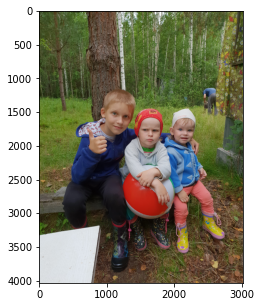

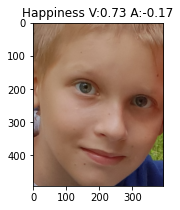

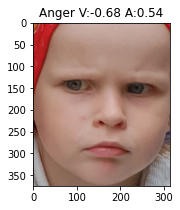

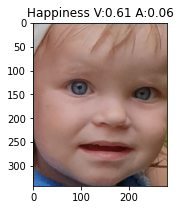

In [47]:
import matplotlib.pyplot as plt
fpath='../test_images/20180720_174416.jpg'
frame_bgr=cv2.imread(fpath)
plt.figure(figsize=(5, 5))
frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
bounding_boxes, points = imgProcessing.detect_faces(frame)
points = points.T
for bbox,p in zip(bounding_boxes, points):
    box = bbox.astype(np.int)
    x1,y1,x2,y2=box[0:4]    
    face_img=frame[y1:y2,x1:x2,:]
    
    img_tensor = test_transforms(Image.fromarray(face_img))
    img_tensor.unsqueeze_(0)
    scores = model(img_tensor.to(device))
    scores=scores[0].data.cpu().numpy()
    plt.figure(figsize=(3, 3))
    plt.imshow(face_img)
    if USE_MTL:
        plt.title(f"{idx_to_class[np.argmax(scores[:8])]} V:{scores[8]:.2f} A:{scores[9]:.2f}")
    else:
        plt.title(idx_to_class[np.argmax(scores)])

In [48]:
imgProcessing.close()

# Feature extractor 

In [13]:
feature_extractor_model = torch.load(PATH)
feature_extractor_model.classifier=torch.nn.Identity()
feature_extractor_model.eval()
feature_extractor_model=feature_extractor_model.to(device)

# AFEW

In [9]:
DATA_DIR=os.path.join(ALL_DATA_DIR,'EmotiW/AFEW/')
print(DATA_DIR)
emotion_to_index = {'Angry':0, 'Disgust':1, 'Fear':2, 'Happy':3, 'Neutral':4, 'Sad':5, 'Surprise':6}

/home/HDD6TB/datasets/emotions/EmotiW/AFEW/


In [14]:
def get_features(data_dir):
    filename2features={}
    for filename in tqdm(os.listdir(data_dir)):
        frames_dir=os.path.join(data_dir,filename)
        X_global_features,X_isface=[],[]
        imgs=[]
        for img_name in os.listdir(frames_dir):
            img = Image.open(os.path.join(frames_dir,img_name))
            img_tensor = test_transforms(img)
            X_isface.append('noface' not in img_name)
                
            if img.size:
                imgs.append(img_tensor)
                if len(imgs)>=16:        
                    #global_features,feats,scores=feature_extractor_model.predict(inp)
                    scores = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                    scores=scores.data.cpu().numpy()
                    #print(scores.shape)
            
                    #print(global_features.shape,feats.shape,scores.shape)
                    if len(X_global_features)==0:
                        X_global_features=scores
                    else:
                        X_global_features=np.concatenate((X_global_features,scores),axis=0)
                    
                    imgs=[]

        if len(imgs)>0:        
            scores = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
            scores=scores.data.cpu().numpy()
            #print(scores.shape)

            #print(global_features.shape,feats.shape,scores.shape)
            if len(X_global_features)==0:
                X_global_features=scores
            else:
                X_global_features=np.concatenate((X_global_features,scores),axis=0)

        X_isface=np.array(X_isface)
        #print(X_global_features.shape,X_feats.shape,X_scores.shape)
        filename2features[filename]=(X_global_features,X_isface)
    return filename2features

filename2features_val=get_features(os.path.join(DATA_DIR,'val/AlignedFaces_LBPTOP_Points_Val/frames_mtcnn_cropped/'))
filename2features_train=get_features(os.path.join(DATA_DIR,'train/AlignedFaces_LBPTOP_Points/frames_mtcnn_cropped/')) #_cropped

  0%|          | 0/383 [00:00<?, ?it/s]

  0%|          | 0/773 [00:00<?, ?it/s]

In [15]:
import pickle
MODEL2EMOTIW_FEATURES=model_name+'_feat_emotiw.pickle' #'_feat_bgr_emotiw.pickle'

#MODEL2EMOTIW_FEATURES='enet0_vggface2_new1_pt_feat_emotiw.pickle'
#MODEL2EMOTIW_FEATURES='enet0_vggface2_pt_feat_emotiw.pickle'
print(MODEL2EMOTIW_FEATURES)

enet0_8_pt_feat_emotiw.pickle


In [49]:
with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump([filename2features_train,filename2features_val], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [269]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    filename2features_train,filename2features_val=pickle.load(handle)
print(len(filename2features_train),len(filename2features_val))

773 383


In [16]:
def create_dataset(filename2features,data_dir):
    x = []
    y = []
    has_faces=[]
    ind=0
    for category in emotion_to_index:
        for filename in os.listdir(os.path.join(data_dir,category)):
            fn=os.path.splitext(filename)[0]
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None
            if True:
                #prev=features[0].shape
                cur_features=features[0][features[-1]==1]
                #print(prev,features.shape)
            else:
                cur_features=features[0]
            if len(cur_features)==0:
                has_faces.append(0)
                total_features=np.zeros_like(feature)
            else:
                has_faces.append(1)
                #mean_features=features.mean(axis=0)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                #feature = np.concatenate((max_features, std_features), axis=None)
                #feature=max_features

                total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(emotion_to_index[category])
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train, y_train, has_faces_train = create_dataset(filename2features_train,os.path.join(DATA_DIR,'train'))
x_test, y_test, has_faces_test = create_dataset(filename2features_val,os.path.join(DATA_DIR,'val'))

(773, 5120) (773,)
(383, 5120) (383,)


In [17]:
x_train_norm=preprocessing.normalize(x_train,norm='l2')
x_test_norm=preprocessing.normalize(x_test,norm='l2')

In [18]:
#clf = svm.LinearSVC(C=3.5) #0.5 1.1
clf = svm.LinearSVC(C=1.1) 
#clf = svm.SVC(kernel='rbf')
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    clf.fit(x_train_norm[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5989445910290238
Complete accuracy: 0.5926892950391645


## Adaptive Frame Rate 

source code for the "Facial Expression Recognition with Adaptive Frame Rate based on Multiple Testing Correction" accepted at ICML 2023

In [24]:
def create_dataset(filename2features,data_dir, is_train=False,stride=1):
    x = []
    y = []
    filenames=[]
    num_frames=[]
    ind=0
    for category in emotion_to_index:
        for filename in os.listdir(os.path.join(data_dir,category)):
            fn=os.path.splitext(filename)[0]
            if not fn in filename2features:
                continue
            features=filename2features[fn]
            total_features=None
            if False and is_train:
                print(fn,features[0].shape,features[0][features[-1]==1].shape)
            if True:
                #prev=features[0].shape
                cur_features=features[0][features[-1]==1]
                #print(prev,features.shape)
            else:
                cur_features=features[0]
            if len(cur_features)==0:
                cur_features=features[0]
                if is_train or True:
                    continue

            cur_features=cur_features[::stride]
            #mean_features=features.mean(axis=0)
            mean_features = (np.mean(cur_features, axis=0))
            std_features = (np.std(cur_features, axis=0))
            max_features = (np.max(cur_features, axis=0))
            min_features = (np.min(cur_features, axis=0))

            # join several features together
            feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
            #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
            #feature = np.concatenate((mean_features, std_features, max_features), axis=None)
            #feature = np.concatenate((max_features, std_features), axis=None)
            #feature = np.concatenate((mean_features, max_features), axis=None)
            
            #feature=min_features
            #feature=std_features
            #feature=max_features
            #feature=mean_features

            total_features=feature
            
            if total_features is not None:
                x.append(total_features)
                y.append(emotion_to_index[category])
                num_frames.append(len(cur_features))
                filenames.append(os.path.join(category,filename))
    x=np.array(x)
    y=np.array(y)
    num_frames=np.array(num_frames)
    #print(x.shape,y.shape)
    return x,y,num_frames,filenames

In [25]:
C=1.1 #0.6 #2.0 #0.5 #0.8 #0.1 0.7
clf = svm.LinearSVC(C=C)
x_train, y_train, num_frames_train,_ = create_dataset(filename2features_train,os.path.join(DATA_DIR,'train'),is_train=True, stride=1)
x_train_norm=preprocessing.normalize(x_train,norm='l2')
clf.fit(x_train_norm, y_train)

for stride in [1,2,3,4,5,6,7,8,9,10,12,15]: #[1]: #
    x_test, y_test, num_frames_test,_ = create_dataset(filename2features_val,os.path.join(DATA_DIR,'val'),is_train=False, stride=stride)
    x_test_norm=preprocessing.normalize(x_test,norm='l2')

    if True:
        y_pred = clf.predict(x_test_norm)
    else:
        decision_values = clf.decision_function(x_test_norm)
        y_pred=decision_values.argmax(axis=1)
        max_decision_values=decision_values.max(axis=1)
    print(stride,metrics.accuracy_score(y_test, y_pred), (max_decision_values>0).mean(),(y_test[max_decision_values>0]==y_pred[max_decision_values>0]).mean())
    #print(delta,str.format('\t{0:.4f}\t{1:.4f}',mord_mse,reg_mse))

1 0.5989445910290238 0.5883905013192612 0.6322869955156951
2 0.5804749340369393 0.5883905013192612 0.6233183856502242
3 0.5725593667546174 0.5883905013192612 0.6143497757847534
4 0.5646437994722955 0.5883905013192612 0.6098654708520179
5 0.5277044854881267 0.5883905013192612 0.57847533632287
6 0.5461741424802111 0.5883905013192612 0.5964125560538116
7 0.5303430079155673 0.5883905013192612 0.5829596412556054
8 0.5408970976253298 0.5883905013192612 0.5874439461883408
9 0.5329815303430079 0.5883905013192612 0.5919282511210763
10 0.5013192612137203 0.5883905013192612 0.5605381165919282
12 0.5277044854881267 0.5883905013192612 0.5919282511210763
15 0.5013192612137203 0.5883905013192612 0.5829596412556054


In [26]:
from sklearn import model_selection

def get_threshold(stride,fpr_corrected):
    x_train_all, y_train_all, _, _ = create_dataset(filename2features_train,os.path.join(DATA_DIR,'train'),is_train=True, stride=stride)
    x_train_all=preprocessing.normalize(x_train_all,norm='l2')

    X_tr, X_val, Y_tr, Y_val = model_selection.train_test_split(x_train_all,y_train_all, test_size=0.5, random_state=42, stratify=y_train_all)
    clf_tmp = svm.LinearSVC(C=clf.C)
    clf_tmp.fit(X_tr, Y_tr)

    decision_values = clf_tmp.decision_function(X_val)
    predictions=decision_values.argmax(axis=1)
    max_decision_values=decision_values.max(axis=1)
    mistakes=max_decision_values[predictions!=Y_val]
    best_threshold=-1
    for i,threshold in enumerate(sorted(max_decision_values[predictions==Y_val])[::-1]):
        tpr=i/len(predictions)
        fpr=(mistakes>threshold).sum()/len(predictions)
        #print(threshold,fpr,tpr)
        if fpr>fpr_corrected:
            if best_threshold==-1:
                best_threshold=threshold
            print('best_threshold',best_threshold,i)
            break
        best_threshold=threshold
    return best_threshold

stride2threshold={}
strides=[18,9,6,3,1]
for s_ind,stride in enumerate(strides):
    fpr_corrected=0.1 #0.1*(s_ind+1)/(len(strides)) #0.08 #
    print('stride',stride,fpr_corrected)
    stride2threshold[stride]=get_threshold(stride,fpr_corrected)


stride 18 0.1
best_threshold 0.08612321740995665 115
stride 9 0.1
best_threshold 0.11035874437126736 124
stride 6 0.1
best_threshold 0.1073352034266093 121
stride 3 0.1
best_threshold 0.1169380934718865 123
stride 1 0.1
best_threshold 0.10636898392038563 122


In [27]:
x_test, y_test, num_frames_test,_ = create_dataset(filename2features_val,os.path.join(DATA_DIR,'val'),is_train=False, stride=1)
x_test_norm=preprocessing.normalize(x_test,norm='l2')
decision_values = clf.decision_function(x_test_norm)
y_pred=decision_values.argmax(axis=1)
print(metrics.accuracy_score(y_test, y_pred))

0.5989445910290238


In [28]:
x_test, y_test, num_frames_test,filenames_test = create_dataset(filename2features_val,os.path.join(DATA_DIR,'val'),is_train=False, stride=1)
num_frames_total=num_frames_test.sum()
all_strides=[
    [18,9,3,1],
    [18,9,1],
    [18,6,1],
    [9,3,1],
    [6,3,1],
    [18,1],
    [9,1],
    [6,1],
    [3,1]
]
#all_strides=[]
for s in stride2threshold.keys():
    all_strides.append([s])
    
for strides in all_strides:
    print(strides)
    last_stride=strides[-1]    
    
    indices=None
    y_pred_seq=None
    total_frames_processed=0
    #for stride,threshold in [(10,0.1),(6,0.3),(1,0)]:
    #for stride,threshold in [(10,0.15),(1,0)]:
    for stride in strides:
        threshold=stride2threshold[stride]
        x_test, y_test, num_frames_test,_ = create_dataset(filename2features_val,os.path.join(DATA_DIR,'val'),is_train=False, stride=stride)
        x_test_norm=preprocessing.normalize(x_test,norm='l2')

        decision_values = clf.decision_function(x_test_norm)
        y_pred=decision_values.argmax(axis=1)
        max_decision_values=decision_values.max(axis=1)
        #print(stride,metrics.accuracy_score(y_test, y_pred), (max_decision_values>threshold).mean(),(y_test[max_decision_values>0]==y_pred[max_decision_values>0]).mean())
        if y_pred_seq is None:
            y_pred_seq=y_pred
            indices=np.array(max_decision_values<=threshold) #np.arange(len(y_test))
            
            if stride==last_stride:
                total_frames_processed+=num_frames_test.sum()
            else:
                total_frames_processed=(num_frames_test[indices==False]).sum()
        else:
            y_pred_seq[indices]=y_pred[indices]
            if stride==last_stride:
                total_frames_processed+=(num_frames_test[indices]).sum()
            else:
                unreliable_indices=np.array(max_decision_values<=threshold)
                cur_frames_processed=(num_frames_test[indices & unreliable_indices==False]).sum()
                total_frames_processed+=cur_frames_processed
                indices=unreliable_indices & indices
    print('Total acc',metrics.accuracy_score(y_test, y_pred_seq),' Num processed frames:',total_frames_processed, total_frames_processed/num_frames_total)


[18, 9, 3, 1]
Total acc 0.6015831134564644  Num processed frames: 15490 0.7759743512674081
[18, 9, 1]
Total acc 0.6015831134564644  Num processed frames: 13165 0.6595030558060314
[18, 6, 1]
Total acc 0.6015831134564644  Num processed frames: 13101 0.6562969642320409
[9, 3, 1]
Total acc 0.5963060686015831  Num processed frames: 15501 0.7765253982566878
[6, 3, 1]
Total acc 0.5989445910290238  Num processed frames: 15810 0.7920048091373609
[18, 1]
Total acc 0.5989445910290238  Num processed frames: 12699 0.6361587015329125
[9, 1]
Total acc 0.5963060686015831  Num processed frames: 13617 0.6821460775473399
[6, 1]
Total acc 0.5989445910290238  Num processed frames: 13636 0.6830978859833684
[3, 1]
Total acc 0.5989445910290238  Num processed frames: 15178 0.760344654844204
[18]
Total acc 0.5145118733509235  Num processed frames: 1286 0.06442240256487326
[9]
Total acc 0.5329815303430079  Num processed frames: 2391 0.1197775773970544
[6]
Total acc 0.5461741424802111  Num processed frames: 3478 

In [29]:
# Complete example
for strides in all_strides:
    print(strides)    
    last_stride=strides[-1]
    
    indices=None
    y_pred_seq=None
    total_frames_processed=0
    #for stride,threshold in [(10,0.1),(6,0.3),(1,0)]:
    #for stride,threshold in [(10,0.15),(1,0)]:
    for s_ind,stride in enumerate(strides):
        if stride!=last_stride:
            fpr_corrected=0.3*(s_ind+1)/(len(strides)) #0.08 #0.1 #
            print('stride',stride,fpr_corrected)
            threshold=get_threshold(stride,fpr_corrected)
        else:
            threshold=0
        
        x_test, y_test, num_frames_test,_ = create_dataset(filename2features_val,os.path.join(DATA_DIR,'val'),is_train=False, stride=stride)
        x_test_norm=preprocessing.normalize(x_test,norm='l2')

        decision_values = clf.decision_function(x_test_norm)
        y_pred=decision_values.argmax(axis=1)
        max_decision_values=decision_values.max(axis=1)
        #print(stride,metrics.accuracy_score(y_test, y_pred), (max_decision_values>threshold).mean(),(y_test[max_decision_values>0]==y_pred[max_decision_values>0]).mean())
        if y_pred_seq is None:
            y_pred_seq=y_pred
            indices=np.array(max_decision_values<=threshold) #np.arange(len(y_test))
            
            if stride==last_stride:
                total_frames_processed+=num_frames_test.sum()
            else:
                total_frames_processed=(num_frames_test[indices==False]).sum()
                print(total_frames_processed,num_frames_test.sum())
        else:
            y_pred_seq[indices]=y_pred[indices]
            if stride==last_stride:
                total_frames_processed+=(num_frames_test[indices]).sum()
            else:
                unreliable_indices=np.array(max_decision_values<=threshold)
                cur_frames_processed=(num_frames_test[indices & unreliable_indices==False]).sum()
                total_frames_processed+=cur_frames_processed
                indices=unreliable_indices & indices
    print('Total acc',metrics.accuracy_score(y_test, y_pred_seq),' Num processed frames:',total_frames_processed, total_frames_processed/num_frames_total)


[18, 9, 3, 1]
stride 18 0.075
best_threshold 0.15087943410466864 102
445 1286
stride 9 0.15
best_threshold 0.01931227660137802 138
stride 3 0.22499999999999998
best_threshold -0.11815472314371855 159
Total acc 0.5936675461741425  Num processed frames: 13456 0.6740807534315199
[18, 9, 1]
stride 18 0.09999999999999999
best_threshold 0.08611320472305128 115
511 1286
stride 9 0.19999999999999998
best_threshold -0.09436104522927136 156
Total acc 0.5910290237467019  Num processed frames: 10615 0.5317603446548442
[18, 6, 1]
stride 18 0.09999999999999999
best_threshold 0.0861118061058318 115
511 1286
stride 6 0.19999999999999998
best_threshold -0.04895691538696789 149
Total acc 0.5989445910290238  Num processed frames: 11700 0.5861136158701533
[9, 3, 1]
stride 9 0.09999999999999999
best_threshold 0.1103475825025616 124
872 2391
stride 3 0.19999999999999998
best_threshold -0.06872089280832505 150
Total acc 0.5963060686015831  Num processed frames: 13810 0.6918144474501553
[6, 3, 1]
stride 6 0.0

In [30]:
#separate classifiers
for strides in all_strides:
    print(strides)    
    last_stride=strides[-1]
    
    indices=None
    y_pred_seq=None
    total_frames_processed=0
    #for stride,threshold in [(10,0.1),(6,0.3),(1,0)]:
    #for stride,threshold in [(10,0.15),(1,0)]:
    for s_ind,stride in enumerate(strides):
        x_train, y_train, num_frames_train,_ = create_dataset(filename2features_train,os.path.join(DATA_DIR,'train'),is_train=True, stride=stride)
        x_train_norm=preprocessing.normalize(x_train,norm='l2')
        clf.fit(x_train_norm, y_train)
        if stride!=last_stride:
            fpr_corrected=0.3*(s_ind+1)/(len(strides)) #0.08 #0.1 #
            print('stride',stride,fpr_corrected)
            threshold=get_threshold(stride,fpr_corrected)
        else:
            threshold=0
        
        x_test, y_test, num_frames_test,_ = create_dataset(filename2features_val,os.path.join(DATA_DIR,'val'),is_train=False, stride=stride)
        x_test_norm=preprocessing.normalize(x_test,norm='l2')

        decision_values = clf.decision_function(x_test_norm)
        y_pred=decision_values.argmax(axis=1)
        max_decision_values=decision_values.max(axis=1)
        #print(stride,metrics.accuracy_score(y_test, y_pred), (max_decision_values>threshold).mean(),(y_test[max_decision_values>0]==y_pred[max_decision_values>0]).mean())
        if y_pred_seq is None:
            y_pred_seq=y_pred
            indices=np.array(max_decision_values<=threshold) #np.arange(len(y_test))
            
            if stride==last_stride:
                total_frames_processed+=num_frames_test.sum()
            else:
                total_frames_processed=(num_frames_test[indices==False]).sum()
                print(total_frames_processed,num_frames_test.sum())
        else:
            y_pred_seq[indices]=y_pred[indices]
            if stride==last_stride:
                total_frames_processed+=(num_frames_test[indices]).sum()
            else:
                unreliable_indices=np.array(max_decision_values<=threshold)
                cur_frames_processed=(num_frames_test[indices & unreliable_indices==False]).sum()
                total_frames_processed+=cur_frames_processed
                indices=unreliable_indices & indices
    print('Total acc',metrics.accuracy_score(y_test, y_pred_seq),' Num processed frames:',total_frames_processed, total_frames_processed/num_frames_total)


[18, 9, 3, 1]
stride 18 0.075
best_threshold 0.15085990615363443 102
431 1286
stride 9 0.15
best_threshold 0.019323074580977817 138
stride 3 0.22499999999999998
best_threshold -0.11815412994815744 159
Total acc 0.5936675461741425  Num processed frames: 13635 0.6830477908025248
[18, 9, 1]
stride 18 0.09999999999999999
best_threshold 0.0861147766938517 115
523 1286
stride 9 0.19999999999999998
best_threshold -0.09436642948726326 156
Total acc 0.5989445910290238  Num processed frames: 10697 0.5358681494840196
[18, 6, 1]
stride 18 0.09999999999999999
best_threshold 0.0861147694505695 115
523 1286
stride 6 0.19999999999999998
best_threshold -0.04896769522533084 149
Total acc 0.5963060686015831  Num processed frames: 11442 0.5731890592125037
[9, 3, 1]
stride 9 0.09999999999999999
best_threshold 0.11035688133207433 124
883 2391
stride 3 0.19999999999999998
best_threshold -0.06871885488541585 150
Total acc 0.5989445910290238  Num processed frames: 13762 0.6894098787696623
[6, 3, 1]
stride 6 0.

# VGAF

In [33]:
DATA_DIR='/home/HDD6TB/datasets/emotions/EmotiW/VGAF/'
print(DATA_DIR)
emotion_to_index = {'Positive':1, 'Neutral':2, 'Negative':3}

/home/HDD6TB/datasets/emotions/EmotiW/VGAF/


In [ ]:
def get_features_scores(data_dir):
    videoname2features={}
    for videoname in tqdm(os.listdir(data_dir)):
        frames_dir=os.path.join(data_dir,videoname)
        X_global_features=[]
        for filename in sorted(os.listdir(frames_dir)):
            faces_dir=os.path.join(frames_dir,filename)
            imgs=[]
            global_features=[]
            for img_name in sorted(os.listdir(faces_dir)):
                img = Image.open(os.path.join(faces_dir,img_name))
                img_tensor = test_transforms(img)
                
                if img.size:
                    imgs.append(img_tensor)
                    if len(imgs)>=32:        
                        #global_features,feats,scores=feature_extractor_model.predict(inp)
                        scores = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                        scores=scores.data.cpu().numpy()
                        #print(scores.shape)

                        if len(global_features)==0:
                            global_features=scores
                        else:
                            global_features=np.concatenate((global_features,scores),axis=0)

                        imgs=[]


            if len(imgs)>0:        
                scores = feature_extractor_model(torch.stack(imgs, dim=0).to(device))
                scores=scores.data.cpu().numpy()
                #print(scores.shape)

                if len(global_features)==0:
                    global_features=scores
                else:
                    global_features=np.concatenate((global_features,scores),axis=0)
                #print(videoname,filename,global_features.shape)
                X_global_features.append(global_features)
        
        #print(videoname,len(X_global_features))
        videoname2features[videoname]=X_global_features
    return videoname2features

video2Allfeatures_val=get_features_scores(os.path.join(DATA_DIR,'preprocessed/Val/mtcnn_aligned'))
video2Allfeatures_train=get_features_scores(os.path.join(DATA_DIR,'preprocessed/Train/mtcnn_aligned'))

  0%|          | 0/766 [00:00<?, ?it/s]

  0%|          | 0/2661 [00:00<?, ?it/s]

In [34]:
#model_name='mobilenet_v1_ft'
#MODEL2EMOTIW_FEATURES=model_name+'_feat_vgaf.pickle' #'_feat_bgr_emotiw.pickle'
MODEL2EMOTIW_FEATURES=model_name+'_feat_vgaf_aligned.pickle'
#MODEL2EMOTIW_FEATURES=model_name+'_feat_emotiw_cropped.pickle'

#MODEL2EMOTIW_FEATURES='enet0_vggface2_new1_pt_feat_vgaf_aligned.pickle'
#MODEL2EMOTIW_FEATURES='enet0_vggface2_pt_feat_vgaf_aligned.pickle'
print(MODEL2EMOTIW_FEATURES)

enet2_8_pt_feat_vgaf_aligned.pickle


In [109]:
with open(MODEL2EMOTIW_FEATURES, 'wb') as handle:
    pickle.dump([video2Allfeatures_train,video2Allfeatures_val], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
with open(MODEL2EMOTIW_FEATURES, 'rb') as handle:
    video2Allfeatures_train,video2Allfeatures_val=pickle.load(handle)
print(len(video2Allfeatures_train),len(video2Allfeatures_val))

2661 766


In [39]:
import csv
def create_dataset(videoname2features,labelsfile):
    x = []
    y = []
    has_faces=[]
    ind=0
    with open(labelsfile, mode='r') as csvfile:
        labels_reader = csv.reader(csvfile, delimiter=' ')
        for i,row in enumerate(labels_reader):
            if i==0:
                #print('first:',row)
                continue
            videoname,label=row[0],int(row[1])
            X_global_features=videoname2features[videoname]
            #print(videoname,label,len(X_global_features))
            
            total_features=[]
            for cur_features in X_global_features:
                #print(cur_features.shape)
                mean_features = (np.mean(cur_features, axis=0))
                std_features = (np.std(cur_features, axis=0))
                max_features = (np.max(cur_features, axis=0))
                min_features = (np.min(cur_features, axis=0))

                # join several features together
                #feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                #feature = np.concatenate((mean_features, min_features, max_features), axis=None)
                feature = np.concatenate((mean_features,std_features), axis=None)
                #feature=max_features
                
                total_features.append(feature)
            
            if len(total_features)>0:
                total_features=np.array(total_features)
                mean_features = (np.mean(total_features, axis=0))
                std_features = (np.std(total_features, axis=0))
                max_features = (np.max(total_features, axis=0))
                min_features = (np.min(total_features, axis=0))

                # join several features together
                #feature = np.concatenate((mean_features, std_features, min_features, max_features), axis=None)                    
                #feature = np.concatenate((mean_features, std_features, min_features), axis=None)
                feature = np.concatenate((mean_features,std_features), axis=None)
                #feature=max_features
                x.append(feature)
                has_faces.append(1)
            else:
                x.append(np.zeros_like(feature))
                has_faces.append(0)
            y.append(label-1)
    x=np.array(x)
    y=np.array(y)
    has_faces=np.array(has_faces)
    print(x.shape,y.shape)
    return x,y,has_faces

x_train, y_train, has_faces_train = create_dataset(video2Allfeatures_train,os.path.join(DATA_DIR,'Train_labels.txt'))
x_test, y_test, has_faces_test = create_dataset(video2Allfeatures_val,os.path.join(DATA_DIR,'Val_labels.txt'))

(2661, 5632) (2661,)
(766, 5632) (766,)


In [40]:
x_train_norm=preprocessing.normalize(x_train,norm='l2')
x_test_norm=preprocessing.normalize(x_test,norm='l2')

In [41]:
#clf = svm.LinearSVC(C=0.01) #0.25 0.5
clf = svm.SVC(kernel='rbf',C=1.9)
#np.random.seed(1)
#clf=RandomForestClassifier(n_estimators=1000,max_depth=7, n_jobs=-1)
#clf=KNeighborsClassifier(n_neighbors=3,p=2)

#import xgboost as xgb
#clf = xgb.XGBClassifier(n_estimators=1000,use_label_encoder=False)

if True:    
    clf.fit(x_train_norm[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test_norm)
else:
    clf.fit(x_train[has_faces_train==1], y_train[has_faces_train==1])
    y_pred = clf.predict(x_test)
print("Accuracy:",metrics.accuracy_score(y_test[has_faces_test==1], y_pred[has_faces_test==1]))
print("Complete accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7044534412955465
Complete accuracy: 0.7023498694516971
